In [1]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# data_link = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
# file = requests.get(data_link)
# with open('names.txt', 'wb') as f:
#   f.write(file.content)

# words = open('names.txt', 'r').read().splitlines()

#alternative approach
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

words = open('names.txt', 'r').read().splitlines()

--2024-06-12 11:08:40--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.01s   

2024-06-12 11:08:40 (19.2 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# comment this part in the repo
word_count = len(words)
max_length = max(len(word) for word in words)
min_length = min(len(word) for word in words)

print(f"{word_count=} \n {max_length=} \n {min_length=}")

word_count=32033 
 max_length=15 
 min_length=2


## Bigram Implementation

In [4]:
# create a lookup table for strings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [5]:
X, Y = [], []
block_size = 3

for word in words:
  context = [0] * block_size
  for ch in word + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

xs = torch.tensor(X)
ys = torch.tensor(Y)


num = xs.nelement()
num

684438

In [6]:
block_size = 3

def build_dataset(words):
  X, Y = [], []
  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182630, 3]) torch.Size([182630])
torch.Size([22630, 3]) torch.Size([22630])
torch.Size([22886, 3]) torch.Size([22886])


In [7]:
# create the weight and biases
vocab_size = len(stoi.values())
embed_dim = 2     # higher embedding dim will improve accuracy by yielding more accurate embedding position
g = torch.Generator().manual_seed(12234556)
C = torch.randn(vocab_size, embed_dim, generator=g) # 27, 2
W1 = torch.randn(3 * embed_dim, 200, generator=g)   # 6, 200
b1 = torch.randn(200, generator=g)  # 200
W2 = torch.randn(200, 27, generator=g)  # 200, 27
b2 = torch.randn(27, generator=g)   # 27
parameters = [C, W1, b1, W2, b2]

for parameter in parameters:
  parameter.requires_grad=True
  #parameter.requires_grad_(True)

# estimating the number of trainable parameters (All the independent values created by the matrices. C is 27 * embed_dim)
sum(p.nelement() for p in parameters)

6881

In [8]:
# finding optimal learning rate
lre = torch.linspace(-3, 0, 1000)  #1000 steps in between
lrs = 10**lre

# storing the loss
lri = []
lossi = []
stepi = []


In [ ]:
#obtaining optimal loss

for i in range(1000):
  #sample a mini batch from the population
  ixs = torch.randint(0, Xtr.shape[0], (32,)) # 32
  ix = Xtr[ixs]  # 32, 3

  # obtain the embedding by looking up from C
  embed = C[ix]   # 32, 3, 2

  h = torch.tanh(embed.view(-1, 3 * embed_dim) @ W1 + b1)  #32, 200
  logits = h @ W2 + b2 # 32, 27

  # Cross Entropy Loss (F.cross_entropy(logits, Ytr[ix]))
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdim=True)  #broadcasting happens with sum (sums all the columns)
  # loss = -probs[torch.arange(ix.shape[0]), Ytr[ixs]].log().mean() + 0.01 * (W2**2).mean()
  loss = F.cross_entropy(logits, Ytr[ixs])
  print(loss.item())

  # backward step
  for p in parameters:
    p.grad = None
  loss.backward()

  #optimization step
  lr = lrs[i]
  #lr = 0.1 if i < 10000 else 0.01 #lr decay
  for p in parameters:
    p.data += -lr * p.grad

  #compile loss and steps
  lri.append(lr)
  stepi.append(i)
  lossi.append(loss.log10().item())


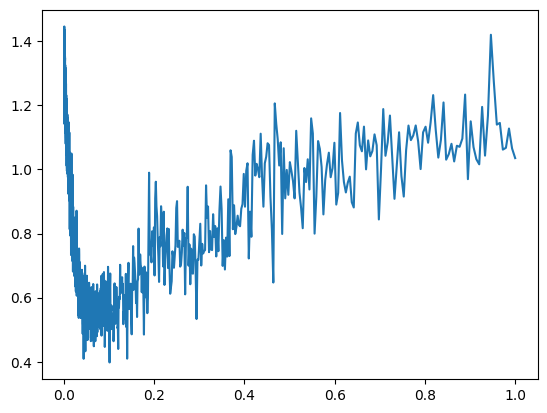

In [10]:
plt.plot(lri, lossi)

In [9]:
# actual training process
for i in range(200000):
  #sample a mini batch from the population
  ixs = torch.randint(0, Xtr.shape[0], (32,)) # 32
  ix = Xtr[ixs]  # 32, 3

  # obtain the embedding by looking up from C
  embed = C[ix]   # 32, 3, 2

  h = torch.tanh(embed.view(-1, 3 * embed_dim) @ W1 + b1)  #32, 200
  logits = h @ W2 + b2 # 32, 27

  '''Cross Entropy Loss and softmax (F.cross_entropy(logits, Ytr[ix]))'''
  #softmax
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdim=True)  #broadcasting happens with sum (sums all the columns)

  #cross entropy
  # loss = -probs[torch.arange(ix.shape[0]), Ytr[ixs]].log().mean() + 0.01 * (W2**2).mean()
  loss = F.cross_entropy(logits, Ytr[ixs])
  #print(loss.item())

  # backward step
  for p in parameters:
    p.grad = None
  loss.backward()

  #optimization step
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 #lr decay
  for p in parameters:
    p.data += -lr * p.grad

  #compile loss and steps
  #lri.append(lr)
  stepi.append(i)
  lossi.append(loss.log10().item())
print(lossi[-1])

0.3563007712364197


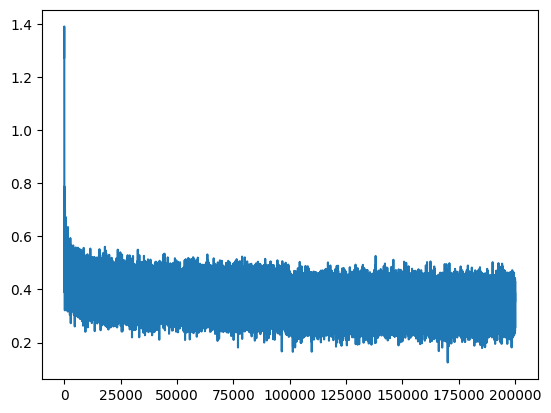

In [10]:
plt.plot(stepi, lossi)

In [11]:
# A single forward pass of all the train data (Same as inference)
# Normally add torch.no_grad or with torch.inference_mode

embed = C[Xtr] # 182630, 3, 2
h = torch.tanh(embed.view(-1, 3 * embed_dim) @ W1 +b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss


tensor(2.2334, grad_fn=<NllLossBackward0>)

In [12]:
# A single forward pass of all the train data (Same as inference)
# Normally add torch.no_grad or with torch.inference_mode

embed = C[Xdev] # 182630, 3, 2
h = torch.tanh(embed.view(-1, 3 * embed_dim) @ W1 +b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2450, grad_fn=<NllLossBackward0>)

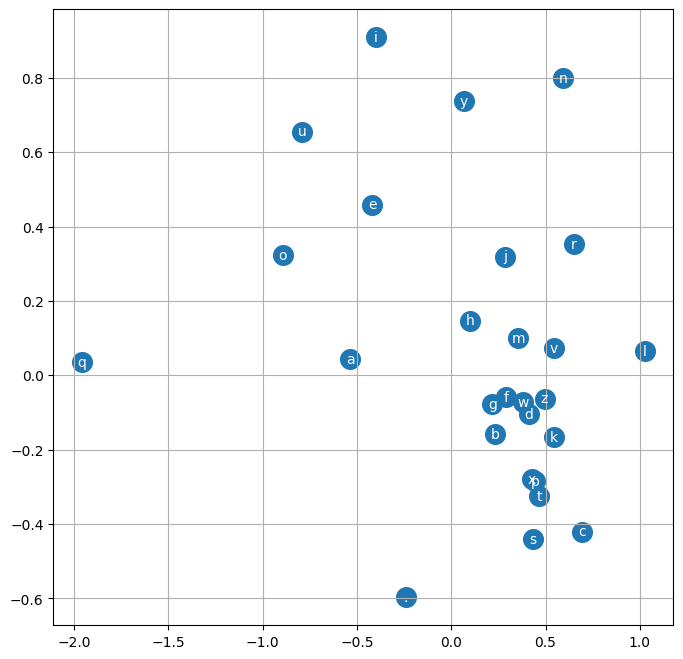

In [16]:
# Since the embedding space is two dimensional, we can plot it.
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)  #remember that shape is 27, 2. we are ploting the two dim as x and y
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), s=itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [26]:
# sampling from the model
g = torch.Generator().manual_seed(1234543)
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    embed = C[torch.tensor(context)]   # 3, 2
    h = torch.tanh(embed.view(1, 3*embed_dim) @ W1 + b1)
    logits = h @ W2 + b2

    #softmax for probabilities
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    #probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    out.append(ix)
    context = context[1:] + [ix]
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))



kamrie.
kianno.
histidpial.
malivu.
dina.
galtamr.
rarlaunya.
rainuesten.
ach.
lany.
aid.
zaan.
afi.
thyanillida.
brio.
sabnith.
cailo.
minfsincie.
kazingzan.
mamiulam.


In [21]:
# Remeber, we cannot index tensors with list or nparrays

context = [0]* block_size
#var_test = C[torch.tensor(context)]   #shape = 3, 2
var_test = C[torch.tensor([context])]  #shape = 1, 3, 2
#var_test = C[torch.tensor([[context]])]  #shape = 1,1,3,2
var_test.shape

torch.Size([1, 3, 2])